In [46]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Install rdkit and conda**

Install rdkit and conda to help us calculate the Lipinski descriptors. **RDKit** is a collection of cheminformatics and machine-learning software written in C++ and Python. 


Conda is an **open-source, cross-platform,language-agnostic package manager** and environment management system. It was originally developed to solve **difficult package management** challenges faced by Python data scientists, and today is a popular package manager for Python and R

In [47]:
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
! conda install -c rdkit rdkit -y
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

--2021-07-19 13:07:29--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85055499 (81M) [application/x-sh]
Saving to: ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh.1’

Miniconda3-py37_4.8 100%[===================>]  81.12M   132MB/s    in 0.6s    

2021-07-19 13:07:30 (132 MB/s) - ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh.1’ saved [85055499/85055499]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: - \ | / - \ | / - \ | / failed with initial frozen solve. Retrying with flexible solve.
Solving environment: \ | / - \ | / - \ failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: \ | / - \ | / - \ | / - 

# **Load Data**

Load **acetylcholinesterase_03_bioactivity_data_curated.csv** data

In [48]:
import pandas as pd

In [49]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Preprocessed Data/human_acetylcholinesterase_03_bioactivity_data_curated.csv")
df

,molecule_chembl_id,canonical_smiles,standard_value,class
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,750.0,active
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,100.0,active
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,50000.0,inactive
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,300.0,active
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,800.0,active
...,...,...,...,...
5038,CHEMBL4554172,Cc1ccc(-c2nc(NC(=O)C3CCN(Cc4cccc(F)c4)CC3)sc2-...,10000.0,inactive
5039,CHEMBL4533844,Cc1ccc(-c2nc(NC(=O)C3CCN(Cc4ccccc4C(F)(F)F)CC3...,7570.0,intermediate
5040,CHEMBL4570655,Cc1ccc(-c2nc(NC(=O)C3CCN(Cc4ccccc4C)CC3)sc2-c2...,10000.0,inactive
5041,CHEMBL4571704,COc1cc(O)c2c(c1)C1=C(c3c(O)c(O)cc(C)c3-c3cc(OC...,15500.0,inactive


Change the column **"canonical_smiles"** to the last column

In [50]:
df_drop_smiles = df.drop(columns='canonical_smiles')

In [51]:
smiles = []

for i in df.canonical_smiles.tolist():
  cpd = str(i).split('.')
  cpd_longest = max(cpd, key = len)
  smiles.append(cpd_longest)

smiles = pd.Series(smiles, name = 'canonical_smiles')

In [52]:
df_chgcolumn_smiles = pd.concat([df_drop_smiles,smiles], axis=1)
df_chgcolumn_smiles

,molecule_chembl_id,standard_value,class,canonical_smiles
0,CHEMBL133897,750.0,active,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1
1,CHEMBL336398,100.0,active,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1
2,CHEMBL131588,50000.0,inactive,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1
3,CHEMBL130628,300.0,active,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F
4,CHEMBL130478,800.0,active,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C
...,...,...,...,...
5038,CHEMBL4554172,10000.0,inactive,Cc1ccc(-c2nc(NC(=O)C3CCN(Cc4cccc(F)c4)CC3)sc2-...
5039,CHEMBL4533844,7570.0,intermediate,Cc1ccc(-c2nc(NC(=O)C3CCN(Cc4ccccc4C(F)(F)F)CC3...
5040,CHEMBL4570655,10000.0,inactive,Cc1ccc(-c2nc(NC(=O)C3CCN(Cc4ccccc4C)CC3)sc2-c2...
5041,CHEMBL4571704,15500.0,inactive,COc1cc(O)c2c(c1)C1=C(c3c(O)c(O)cc(C)c3-c3cc(OC...


# **Calculate Lipinski descriptors**

Lipinski's rule of five, also known as Pfizer's rule of five or simply the rule of five (RO5), is a rule of thumb to evaluate **druglikeness** or determine if a chemical compound with a certain **pharmacological** or **biological activity** has chemical properties and physical properties that would make it a likely **orally active drug** in humans. 

The Lipinski's Rule stated the following:
*   Molecular weight must be < 500 daltons
*   Octanol-water partition coefficient (LogP) < 5
* Hydrogen bond donors < 5
* Hydrogen bond acceptors < 10

**Import required libraries**

In [53]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

**Calculate descriptors**

In [54]:
def lipinski(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem) 
        moldata.append(mol)
       
    baseData= np.arange(1,1)
    i=0  
    for mol in moldata:        
       
        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)
           
        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])   
    
        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1      
    
    columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]   
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)
    
    return descriptors

In [55]:
df_lipinski = lipinski(df_chgcolumn_smiles.canonical_smiles)

# **Concatenate the dataframe namely df with df_lipinski.**

In [56]:
df_lipinski

,MW,LogP,NumHDonors,NumHAcceptors
0,312.325,2.80320,0.0,6.0
1,376.913,4.55460,0.0,5.0
2,426.851,5.35740,0.0,5.0
3,404.845,4.70690,0.0,5.0
4,346.334,3.09530,0.0,6.0
...,...,...,...,...
5038,499.655,7.08374,1.0,4.0
5039,549.662,7.96344,1.0,4.0
5040,495.692,7.25306,1.0,4.0
5041,576.510,4.06432,6.0,11.0


In [57]:
df

,molecule_chembl_id,canonical_smiles,standard_value,class
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,750.0,active
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,100.0,active
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,50000.0,inactive
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,300.0,active
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,800.0,active
...,...,...,...,...
5038,CHEMBL4554172,Cc1ccc(-c2nc(NC(=O)C3CCN(Cc4cccc(F)c4)CC3)sc2-...,10000.0,inactive
5039,CHEMBL4533844,Cc1ccc(-c2nc(NC(=O)C3CCN(Cc4ccccc4C(F)(F)F)CC3...,7570.0,intermediate
5040,CHEMBL4570655,Cc1ccc(-c2nc(NC(=O)C3CCN(Cc4ccccc4C)CC3)sc2-c2...,10000.0,inactive
5041,CHEMBL4571704,COc1cc(O)c2c(c1)C1=C(c3c(O)c(O)cc(C)c3-c3cc(OC...,15500.0,inactive


Concatenate the 2 dataframes, **df** and **df_lipinski**

In [58]:
df_concatenate = pd.concat([df,df_lipinski], axis=1)
df_concatenate

,molecule_chembl_id,canonical_smiles,standard_value,class,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,750.0,active,312.325,2.80320,0.0,6.0
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,100.0,active,376.913,4.55460,0.0,5.0
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,50000.0,inactive,426.851,5.35740,0.0,5.0
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,300.0,active,404.845,4.70690,0.0,5.0
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,800.0,active,346.334,3.09530,0.0,6.0
...,...,...,...,...,...,...,...,...
5038,CHEMBL4554172,Cc1ccc(-c2nc(NC(=O)C3CCN(Cc4cccc(F)c4)CC3)sc2-...,10000.0,inactive,499.655,7.08374,1.0,4.0
5039,CHEMBL4533844,Cc1ccc(-c2nc(NC(=O)C3CCN(Cc4ccccc4C(F)(F)F)CC3...,7570.0,intermediate,549.662,7.96344,1.0,4.0
5040,CHEMBL4570655,Cc1ccc(-c2nc(NC(=O)C3CCN(Cc4ccccc4C)CC3)sc2-c2...,10000.0,inactive,495.692,7.25306,1.0,4.0
5041,CHEMBL4571704,COc1cc(O)c2c(c1)C1=C(c3c(O)c(O)cc(C)c3-c3cc(OC...,15500.0,inactive,576.510,4.06432,6.0,11.0


# **Convert IC50 to pIC50**

IC50 is a measure of the potency of a substance in inhibiting a specific biological or biochemical function. IC50 is a quantitative measure that indicates how much of a particular inhibitory substance (e.g. drug) is needed to inhibit, in vitro, a given biological process or biological component by 50%

We will convert IC50 to the negative logarithmic scale which is essentially **-log10(IC50)**, to allow the data to be more uniformly distributed

In [59]:
import numpy as np

def pIC50(input):
    pIC50 = []

    for i in input['standard_value_normalize']:
        molar = i*(10**-9) # Converts nM to M
        pIC50.append(-np.log10(molar))

    input['pIC50'] = pIC50
    x = input.drop('standard_value_normalize', 1)
        
    return x

In [60]:
df_concatenate.standard_value.describe()

count    5.043000e+03
mean     2.989356e+12
std      1.147822e+14
min      5.000000e-06
25%      1.218000e+02
50%      2.090000e+03
75%      1.540000e+04
max      5.888437e+15
Name: standard_value, dtype: float64

Normalize the value in the **standard_value** column

In [61]:
def normalize_value(input):
    norm = []

    for i in input['standard_value']:
        if i > 100000000:
          i = 100000000
        norm.append(i)

    input['standard_value_normalize'] = norm
    x = input.drop('standard_value', 1)
        
    return x

In [62]:
df_normalize = normalize_value(df_concatenate)
df_normalize

,molecule_chembl_id,canonical_smiles,class,MW,LogP,NumHDonors,NumHAcceptors,standard_value_normalize
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,active,312.325,2.80320,0.0,6.0,750.0
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,active,376.913,4.55460,0.0,5.0,100.0
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,inactive,426.851,5.35740,0.0,5.0,50000.0
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,active,404.845,4.70690,0.0,5.0,300.0
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,active,346.334,3.09530,0.0,6.0,800.0
...,...,...,...,...,...,...,...,...
5038,CHEMBL4554172,Cc1ccc(-c2nc(NC(=O)C3CCN(Cc4cccc(F)c4)CC3)sc2-...,inactive,499.655,7.08374,1.0,4.0,10000.0
5039,CHEMBL4533844,Cc1ccc(-c2nc(NC(=O)C3CCN(Cc4ccccc4C(F)(F)F)CC3...,intermediate,549.662,7.96344,1.0,4.0,7570.0
5040,CHEMBL4570655,Cc1ccc(-c2nc(NC(=O)C3CCN(Cc4ccccc4C)CC3)sc2-c2...,inactive,495.692,7.25306,1.0,4.0,10000.0
5041,CHEMBL4571704,COc1cc(O)c2c(c1)C1=C(c3c(O)c(O)cc(C)c3-c3cc(OC...,inactive,576.510,4.06432,6.0,11.0,15500.0


In [63]:
df_normalize.standard_value_normalize.describe()

count    5.043000e+03
mean     3.063436e+05
std      4.553341e+06
min      5.000000e-06
25%      1.218000e+02
50%      2.090000e+03
75%      1.540000e+04
max      1.000000e+08
Name: standard_value_normalize, dtype: float64

In [64]:
df_final = pIC50(df_normalize)
df_final

,molecule_chembl_id,canonical_smiles,class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,active,312.325,2.80320,0.0,6.0,6.124939
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,active,376.913,4.55460,0.0,5.0,7.000000
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,inactive,426.851,5.35740,0.0,5.0,4.301030
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,active,404.845,4.70690,0.0,5.0,6.522879
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,active,346.334,3.09530,0.0,6.0,6.096910
...,...,...,...,...,...,...,...,...
5038,CHEMBL4554172,Cc1ccc(-c2nc(NC(=O)C3CCN(Cc4cccc(F)c4)CC3)sc2-...,inactive,499.655,7.08374,1.0,4.0,5.000000
5039,CHEMBL4533844,Cc1ccc(-c2nc(NC(=O)C3CCN(Cc4ccccc4C(F)(F)F)CC3...,intermediate,549.662,7.96344,1.0,4.0,5.120904
5040,CHEMBL4570655,Cc1ccc(-c2nc(NC(=O)C3CCN(Cc4ccccc4C)CC3)sc2-c2...,inactive,495.692,7.25306,1.0,4.0,5.000000
5041,CHEMBL4571704,COc1cc(O)c2c(c1)C1=C(c3c(O)c(O)cc(C)c3-c3cc(OC...,inactive,576.510,4.06432,6.0,11.0,4.809668


In [65]:
df_final.pIC50.describe()

count    5043.000000
mean        5.863164
std         1.612500
min         1.000000
25%         4.812479
50%         5.679854
75%         6.914353
max        14.301030
Name: pIC50, dtype: float64

In [66]:
df_final.to_csv('human_acetylcholinesterase_04_bioactivity_data_3class_pIC50.csv')

# **Remove "Intermediate" class**

In [67]:
df_rmv_intermediate_class = df_final[df_final['class'] != 'intermediate']
df_rmv_intermediate_class

,molecule_chembl_id,canonical_smiles,class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,active,312.325,2.80320,0.0,6.0,6.124939
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,active,376.913,4.55460,0.0,5.0,7.000000
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,inactive,426.851,5.35740,0.0,5.0,4.301030
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,active,404.845,4.70690,0.0,5.0,6.522879
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,active,346.334,3.09530,0.0,6.0,6.096910
...,...,...,...,...,...,...,...,...
5036,CHEMBL4578266,Cc1ccc(-c2nc(NC(=O)C3CCN(Cc4ccc(F)cc4Cl)CC3)sc...,inactive,534.100,7.73714,1.0,4.0,5.000000
5038,CHEMBL4554172,Cc1ccc(-c2nc(NC(=O)C3CCN(Cc4cccc(F)c4)CC3)sc2-...,inactive,499.655,7.08374,1.0,4.0,5.000000
5040,CHEMBL4570655,Cc1ccc(-c2nc(NC(=O)C3CCN(Cc4ccccc4C)CC3)sc2-c2...,inactive,495.692,7.25306,1.0,4.0,5.000000
5041,CHEMBL4571704,COc1cc(O)c2c(c1)C1=C(c3c(O)c(O)cc(C)c3-c3cc(OC...,inactive,576.510,4.06432,6.0,11.0,4.809668


Write this to csv file

In [68]:
df_rmv_intermediate_class.to_csv('human_acetylcholinesterase_05_bioactivity_2_class_pIC50.csv')

# **Exploratory Data Analysis**

Import matplotlib and seaborn to plot graphs

In [69]:
import seaborn as sns
sns.set(style='ticks')
import matplotlib.pyplot as plt

Plot the **bioactivity class** and the **number for each class**

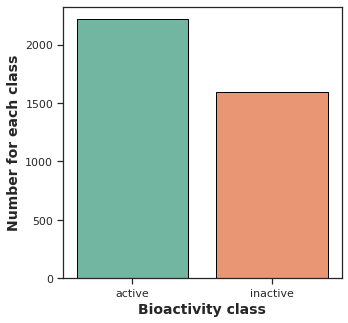

In [70]:
plt.figure(figsize=(5.0, 5.0))

sns.countplot(x='class', data=df_rmv_intermediate_class, edgecolor='black', palette="Set2")

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('Number for each class', fontsize=14, fontweight='bold')

plt.savefig('plot_bioactivity_class.pdf')

In [71]:
df_rmv_intermediate_class.describe()

,MW,LogP,NumHDonors,NumHAcceptors,pIC50
count,3809.000000,3809.000000,3809.000000,3809.000000,3809.000000
mean,403.380606,4.455924,1.149383,4.355736,5.996134
std,125.389039,2.083130,1.128787,1.855959,1.828880
min,61.040000,-2.425900,0.000000,0.000000,1.000000
25%,320.480000,3.036700,0.000000,3.000000,4.522879
50%,391.511000,4.334000,1.000000,4.000000,6.259637
75%,471.553000,5.602400,2.000000,5.000000,7.236572
max,1151.423000,13.506800,10.000000,16.000000,14.301030


Scatter plot of **Molecular Weight** and **LogP**

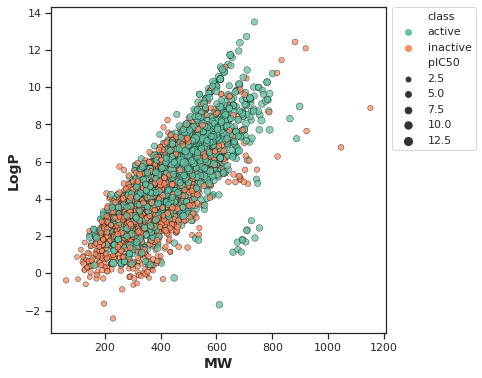

In [72]:
plt.figure(figsize=(6.0, 6.0))

sns.scatterplot(x='MW', y='LogP', data=df_rmv_intermediate_class, hue='class', size='pIC50', edgecolor='black', alpha=0.75,palette="Set2")

plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0)
plt.savefig('plot_MW_vs_LogP.pdf', bbox_inches = 'tight')

Box Plot for **pIC50 value** vs **bioactivity class**

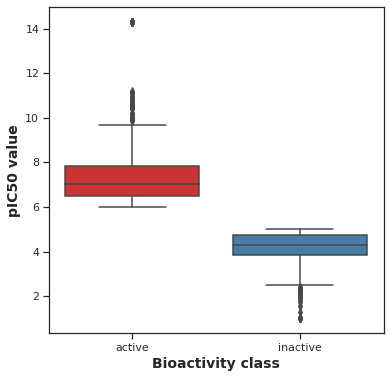

In [73]:
plt.figure(figsize=(6.0, 6.0))

sns.boxplot(x = 'class', y = 'pIC50', data = df_rmv_intermediate_class, palette="Set1")

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('pIC50 value', fontsize=14, fontweight='bold')

plt.savefig('plot_ic50.pdf')

Statistical analysis

In [74]:
def mannwhitney(descriptor, verbose=False):
  from numpy.random import seed
  from numpy.random import randn
  from scipy.stats import mannwhitneyu

# seed the random number generator
  seed(1)

# actives and inactives
  selection = [descriptor, 'class']
  df = df_rmv_intermediate_class[selection]
  active = df[df['class'] == 'active']
  active = active[descriptor]

  selection = [descriptor, 'class']
  df = df_rmv_intermediate_class[selection]
  inactive = df[df['class'] == 'inactive']
  inactive = inactive[descriptor]

# compare samples
  stat, p = mannwhitneyu(active, inactive)
  #print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
  alpha = 0.05
  if p > alpha:
    interpretation = 'Same distribution (fail to reject H0)'
  else:
    interpretation = 'Different distribution (reject H0)'
  
  results = pd.DataFrame({'Descriptor':descriptor,
                          'Statistics':stat,
                          'p':p,
                          'alpha':alpha,
                          'Interpretation':interpretation}, index=[0])
  filename = 'mannwhitneyu_' + descriptor + '.csv'
  results.to_csv(filename)

  return results

In [75]:
mannwhitney('pIC50')

,Descriptor,Statistics,p,alpha,Interpretation
0,pIC50,0.0,0.0,0.05,Different distribution (reject H0)


Molecular Weight

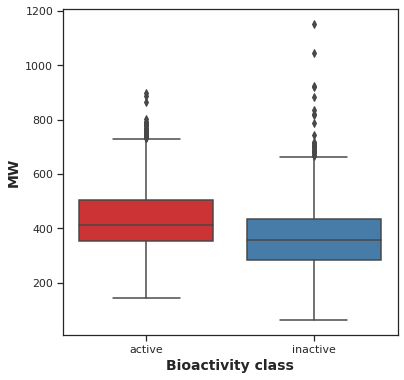

In [76]:
plt.figure(figsize=(6.0, 6.0))

sns.boxplot(x = 'class', y = 'MW', data = df_rmv_intermediate_class,palette="Set1")

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('MW', fontsize=14, fontweight='bold')

plt.savefig('plot_MW.pdf')

In [77]:
mannwhitney('MW')

,Descriptor,Statistics,p,alpha,Interpretation
0,MW,1207234.0,1.090277e-62,0.05,Different distribution (reject H0)


LogP

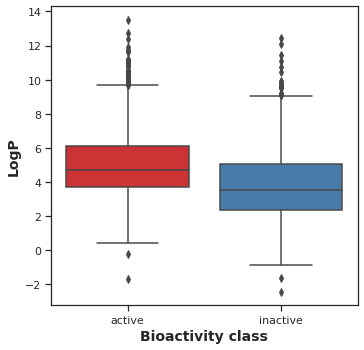

In [78]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'LogP', data = df_rmv_intermediate_class, palette="Set1")

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')

plt.savefig('plot_LogP.pdf')

In [79]:
mannwhitney('LogP')

,Descriptor,Statistics,p,alpha,Interpretation
0,LogP,1176292.5,1.375556e-69,0.05,Different distribution (reject H0)


NumHDonors

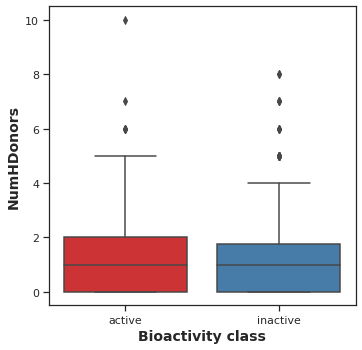

In [80]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'NumHDonors', data = df_rmv_intermediate_class,palette="Set1")

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHDonors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHDonors.pdf')

In [81]:
mannwhitney('NumHDonors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHDonors,1524372.5,2.121353e-14,0.05,Different distribution (reject H0)


NumHAcceptors

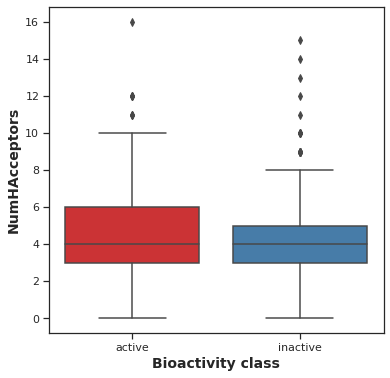

In [82]:
plt.figure(figsize=(6.0, 6.0))

sns.boxplot(x = 'class', y = 'NumHAcceptors', data = df_rmv_intermediate_class, palette="Set1")

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHAcceptors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHAcceptors.pdf')

In [83]:
mannwhitney('NumHAcceptors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHAcceptors,1636225.0,0.000044,0.05,Different distribution (reject H0)


In [84]:
df_rmv_intermediate_class = df_final[df_final['class'] != 'intermediate']
df_rmv_intermediate_class

,molecule_chembl_id,canonical_smiles,class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,active,312.325,2.80320,0.0,6.0,6.124939
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,active,376.913,4.55460,0.0,5.0,7.000000
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,inactive,426.851,5.35740,0.0,5.0,4.301030
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,active,404.845,4.70690,0.0,5.0,6.522879
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,active,346.334,3.09530,0.0,6.0,6.096910
...,...,...,...,...,...,...,...,...
5036,CHEMBL4578266,Cc1ccc(-c2nc(NC(=O)C3CCN(Cc4ccc(F)cc4Cl)CC3)sc...,inactive,534.100,7.73714,1.0,4.0,5.000000
5038,CHEMBL4554172,Cc1ccc(-c2nc(NC(=O)C3CCN(Cc4cccc(F)c4)CC3)sc2-...,inactive,499.655,7.08374,1.0,4.0,5.000000
5040,CHEMBL4570655,Cc1ccc(-c2nc(NC(=O)C3CCN(Cc4ccccc4C)CC3)sc2-c2...,inactive,495.692,7.25306,1.0,4.0,5.000000
5041,CHEMBL4571704,COc1cc(O)c2c(c1)C1=C(c3c(O)c(O)cc(C)c3-c3cc(OC...,inactive,576.510,4.06432,6.0,11.0,4.809668


Zip files


In [85]:
! zip -r results.zip . -i *.csv *.pdf

updating: mannwhitneyu_pIC50.csv (deflated 14%)
updating: plot_NumHAcceptors.pdf (deflated 38%)
updating: plot_LogP.pdf (deflated 37%)
updating: mannwhitneyu_NumHAcceptors.csv (deflated 10%)
updating: human_acetylcholinesterase_04_bioactivity_data_3class_pIC50.csv (deflated 76%)
updating: mannwhitneyu_MW.csv (deflated 9%)
updating: plot_ic50.pdf (deflated 36%)
updating: plot_MW_vs_LogP.pdf (deflated 2%)
updating: mannwhitneyu_LogP.csv (deflated 9%)
updating: mannwhitneyu_NumHDonors.csv (deflated 11%)
updating: plot_bioactivity_class.pdf (deflated 38%)
updating: plot_MW.pdf (deflated 38%)
updating: plot_NumHDonors.pdf (deflated 38%)
updating: human_acetylcholinesterase_05_bioactivity_2_class_pIC50.csv (deflated 76%)
